## This notebook is based on the works:

1) **[Naive LightGBM](https://www.kaggle.com/code/bguberfain/naive-lightgbm)** by master [*Bruno G. do Amaral*](https://www.kaggle.com/bguberfain)


2) **[Tabular Ensemble: LGBM+Catboost](https://www.kaggle.com/code/snnclsr/tabular-ensemble-lgbm-catboost)** by master [*Sinan Calisir*](https://www.kaggle.com/snnclsr)


3) **[ISIC 2024 Skin Cancer - Getting Started](https://www.kaggle.com/code/coderinunderpants/isic-2024-skin-cancer-getting-started)** by contributor [*Joy Banikl*](https://www.kaggle.com/coderinunderpants)


4) **[ISIC: Tabular model + Image model features](https://www.kaggle.com/code/motono0223/isic-tabular-model-image-model-features)** by master [*motono0223*](https://www.kaggle.com/motono0223)


5) **[Only Tabular Features: XGB+CATB+LGBM Ensemble](https://www.kaggle.com/code/rzatemizel/only-tabular-features-xgb-catb-lgbm-ensemble)** by master [*rıza temizel*](https://www.kaggle.com/rzatemizel)


6) **[Tabular with Image features](https://www.kaggle.com/code/merfarukelik/tabular-with-image-features)** by contributor [*Ömer faruk çelik*](https://www.kaggle.com/merfarukelik)


7) **[Tabular Ensemble: LGBM + Catboost | Add EdgeNext](https://www.kaggle.com/code/hugowjd/tabular-ensemble-lgbm-catboost-add-edgenext)** by expert [*Jiadi Wang*](https://www.kaggle.com/hugowjd)


8) **[ISIC 2024 | Only Tabular Data](https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data)** by master [*Farukcan Saglam*](https://www.kaggle.com/greysky)


9) **[LGBM - CAT Ensemble --> ISIC](https://www.kaggle.com/code/abdmental01/lgbm-cat-ensemble-isic)** by grandmaster [*Sheikh Muhammad Abdullah*](https://www.kaggle.com/abdmental01)


10) **[ISIC - Detect Skin Cancer - Let's Learn Together](https://www.kaggle.com/code/dschettler8845/isic-detect-skin-cancer-let-s-learn-together)** by grandmaster [*Darien Schettler*](https://www.kaggle.com/dschettler8845)


11) **[ISIC 2024 Skin Cancer Detection hdf5](https://www.kaggle.com/code/mpwolke/isic-2024-skin-cancer-detection-hdf5)** by grandmaster [*Marília Prata*](https://www.kaggle.com/mpwolke)


12) **[AI in Dermoscopy. ADAE algorithm.](https://www.kaggle.com/competitions/isic-2024-challenge/discussion/515369)** by grandmaster [*Marília Prata*](https://www.kaggle.com/mpwolke)


## Mixing with a Densenet 169 image model
- The principle is to combine a new model, consisting of images otherwise curated, to a project already well performing. 
- The present version uses densenet 169 for the added model; The training of the added model was done on Colab (notebook: https://colab.research.google.com/drive/1tEGRaA5WaKYQbHQzy9cAg4MKSyyIXwUo?usp=drive_link).
- the best mixing formula is infered from the entire 2024 dataset predictions used as proxy for the final testing set. Scipy RepeatedStratifiedKFold was used for this purpose.
    see: https://colab.research.google.com/drive/19BDBpgPl8E_eQNIIV6Tu4G3nMfDxUPeq?usp=drive_link
- the mixing formula is linear-correl-quadratic and the method is Powell. Nelder-Mead and BGSF were dismissed because convergence issues. 
- the training dataset is made of entries from the 20218, 2019, 2020 and 2024 datasets. 
- the train dataset has the 2024-original replicated 14 times and the past minority is not replicated. 
- the majority (negative cases) is 2 times greater than the minority and includes only cases from 2024.
- the best weights are obtained for epoch 8 which had the lower loss. 

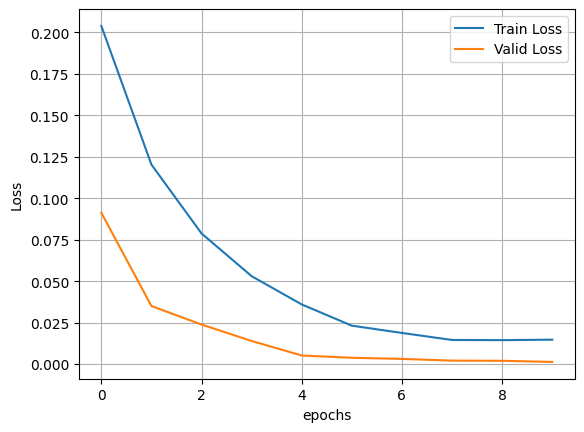


In [1]:
#for mix formula
import numpy as np
import pandas as pd

from scipy.optimize import minimize
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, auc

df_my_mix_tabular= pd.read_csv("/kaggle/input/predictions-of-2024-dataset/predictions_of_2024_dataset_notebook4.csv") 
df_my_mix_tabular.rename(columns={'target': 'preds'}, inplace=True)
df_my_mix_tabular['target'] = 0 #dummy
df_my_mix_image= pd.read_csv("/kaggle/input/rep14-output-zinneke-picture-train/rep14-output-zinneke-picture-train-d169/df_2024_after prediction.csv")

def pAUC_aboveTPR(y_score, y_true, max_fpr):

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(y_true, y_score, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    #print(tpr, fpr)
    partial_auc = auc(fpr, tpr)
    #print("partial_auc_scaled", partial_auc, "\n")
    #plt.plot(fpr,tpr,label=name + ", pAUC-aboveTPR =" + str(partial_auc))
    #plt.legend()
    #plt.show()
    return partial_auc

min_tpr = 0.80
max_fpr = abs(1-min_tpr)
merged_train = pd.merge(df_my_mix_tabular, df_my_mix_image,
                                               on = 'isic_id')
formula_dic = {"linear":2, "linear-intercept":3, "linear-correl":3, "linear-correl-intercept":4,
                "linear-quadratic": 4, "linear-quadratic-intercept":5, "linear-correl-quadratic":5,
                "linear-correl-quadratic-intercept": 6}

def predict_formula(x0, y1, y2, formula):
  if formula == "linear" :
    y = x0[0]*y1 + x0[1]*y2
  elif formula == "linear-intercept" :
    y = x0[0]*y1 + x0[1]*y2 + x0[2]
  elif formula == "linear-correl" :
    y = x0[0]*y1 + x0[1]*y2 + x0[2]*y1*y2
  elif formula == "linear-correl-intercept":
    y = x0[0]*y1 + x0[1]*y2 + x0[2]*y1*y2 + x0[3]
  elif formula == "linear-quadratic" :
    y = x0[0]*y1+x0[1]*y2+x0[2]*y1*y1+x0[3]*y2*y2
  elif formula == "linear-quadratic-intercept" :
    y = x0[0]*y1+x0[1]*y2+x0[2]*y1*y1+x0[3]*y2*y2+ x0[4]
  elif formula == "linear-correl-quadratic" :
    y = x0[0]*y1+x0[1]*y2+x0[2]*y1*y2+x0[3]*y1*y1+x0[4]*y2*y2
  elif formula == "linear-correl-quadratic-intercept" :
    y = x0[0]*y1+x0[1]*y2+x0[2]*y1*y2+x0[3]*y1*y1+x0[4]*y2*y2 + x0[5]

  return y

def fun(x0, y1, y2, y_true, max_fpr, formula = "linear"):
  y =  predict_formula(x0, y1, y2, formula)
  pauc =  pAUC_aboveTPR(y, y_true, max_fpr)
  return - pauc

print("pAUC mix1", pAUC_aboveTPR(merged_train["preds_x"],merged_train["target_y"], max_fpr))

print("pAUC mix2",pAUC_aboveTPR(merged_train["preds_y"],merged_train["target_y"], max_fpr))

pAUC mix1 0.19777298914355942
pAUC mix2 0.1998744012339048


In [2]:
# specific to the model mix;, determined on Colab notebook

formula_name = "linear-correl-quadratic" 
method = "powell"

In [3]:
def get_minimization_parameter():
    res = minimize(fun, formula_dic[formula_name]*[0],
                    args = (merged_train["preds_x"],
                            merged_train["preds_y"],
                            merged_train["target_y"], max_fpr,
                            formula_name),
                   options={'disp': True},
                   method= method,
                          )
    return res.fun, res.x

In [4]:
#res_fun, res_x = get_minimization_parameter() # not used here
# not used here:
# copy from optimization notebook in Colab
res_fun = (0.19994093 + 0.19993711)/2 # mean of train and test splits in RepeatedStratifiedKFold
res_x = [ 2.65665278e+00 , 8.21484926e+01, -4.72671428e-01, -2.90088313e-01, -1.32967800e-02]
print("optimum", res_fun)
print("parameters "+method+" "+formula_name +":", res_x)
merged_train["preds"] = predict_formula(res_x, merged_train["preds_x"],
                        merged_train["preds_y"], formula=formula_name)
merged_train.sort_values(by=['isic_id']).head(3)

hybrid_train = merged_train[['isic_id', 'target_y', 'preds']].copy()
hybrid_train.rename(columns={'target_y': 'target'}, inplace=True)
hybrid_train.sort_values(by=['isic_id']).head(3)

# normalization
hybrid_train['preds'] = (hybrid_train['preds'] - hybrid_train['preds'].min()) / \
                        (hybrid_train['preds'].max() - hybrid_train['preds'].min())
print("pAUC after mix", pAUC_aboveTPR(hybrid_train["preds"],hybrid_train["target"], max_fpr))

optimum 0.19993902
parameters powell linear-correl-quadratic: [2.65665278, 82.1484926, -0.472671428, -0.290088313, -0.01329678]
pAUC after mix 0.19993943925603053


In [5]:
# import for image model prediction
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from pathlib import Path
import h5py
from PIL import Image
from io import BytesIO

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
#from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, train_test_split
from sklearn.metrics import auc, roc_curve

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
# from colorama import Fore, Back, Style
# b_ = Fore.BLUE
# sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Plot package
import PIL

from matplotlib import pyplot as plt

In [6]:
# for remembering the setting of the training phase #
#(not obligatory the setting of the training notebook)
CONFIG = {
    "seed": 42,
    "epochs": 10,
    "img_size": 224, # for b0 # 288, # was 384,
    #"model_name": "tf_efficientnet_b3_ns",
    "model_name": "densenet169.tv_in1k",
    #"checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b3/1/tf_efficientnet_b3_aa-84b4657e.pth",
    #"checkpoint_path" : "/kaggle/input/pdc_efficientnet/pytorch/default/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 5e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 5e-7,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "replicate_pos" : 14,
    "target_ratio" : 2,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [7]:
CONFIG['device']

device(type='cuda', index=0)

In [8]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seeding done ...")

def flush():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
set_seed(CONFIG['seed'])

ROOT_DIR = "/kaggle/input/isic-2024-challenge"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'
TEST_DIR = f'{ROOT_DIR}/test-image.hdf5/image'

TEST_CSV = f'{ROOT_DIR}/test-metadata.csv'
TEST_HDF = f'{ROOT_DIR}/test-image.hdf5'
SAMPLE = f'{ROOT_DIR}/sample_submission.csv'

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)

    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)
        #self.model = timm.create_model(model_name, pretrained=pretrained)
        #self.model = torchvision.models.efficientnet_b0(weights = 'DEFAULT')
        #print(self.model)
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.sigmoid(self.linear(pooled_features))
        return output

torch.cuda.empty_cache()
model = torch.load("/kaggle/input/rep14-output-zinneke-picture-train/rep14-output-zinneke-picture-train-d169/zinneke_picture.pt")

### Read the data
class ISICDataset_for_Test(Dataset):
    def __init__(self, df, file_hdf, transforms=None):
        self.df = df
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.targets = df['target'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        img = np.array( Image.open(BytesIO(self.fp_hdf[isic_id][()])) )
        target = self.targets[index]

        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target,
        }
# Load submission data
subm_data = pd.read_csv(TEST_CSV)
subm_data['target'] = 0 # dummy
display(subm_data.head())

data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1,
                           scale_limit=0.15,
                           rotate_limit=60,
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2,
                sat_shift_limit=0.2,
                val_shift_limit=0.2,
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1),
                contrast_limit=(-0.1, 0.1),
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

### Start inference

test_post_dataset = ISICDataset_for_Test(subm_data, TEST_HDF, transforms=data_transforms["valid"])
test_post_loader = DataLoader(test_post_dataset, batch_size=CONFIG['valid_batch_size'],
                          num_workers=2, shuffle=False, pin_memory=True)
preds_test = []
with torch.no_grad():
    bar = tqdm(enumerate(test_post_loader), total=len(test_post_loader))
    for step, data in bar:
        images = data['image'].to(CONFIG["device"], dtype=torch.float)
        batch_size =  images.size(0)
        outputs = model(images)
        preds_test.append( outputs.detach().cpu().numpy() )
preds_test = np.concatenate(preds_test).flatten()

# Assign predictions to submission DataFrame # this seems correct
subm_data["preds"] = preds_test
display(subm_data.head())

Seeding done ...


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,target
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY,0
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY,0
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY,0


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,target,preds
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY,0,9.817754e-09
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY,0,3.748532e-06
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY,0,1.669658e-04


## [Turkish Master](https://www.kaggle.com/greysky) [work](https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data):

In [9]:
import os
import gc
import time
import copy
import optuna

from pathlib import Path

import numpy as np, pandas as pd, polars as pl

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import VotingClassifier

from sklearn.utils import resample

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

import lightgbm as lgb, catboost as cb, xgboost as xgb

from optuna.samplers import TPESampler

from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
# from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import NearMiss, TomekLinks
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin

# IMAGE PREDICTIONS

In [10]:
#EFFNET V1B0
!python /kaggle/input/isic-script-inference-effnetv1b0-f313ae/main.py /kaggle/input/isic-pytorch-training-baseline-image-only/AUROC0.5171_Loss0.3476_epoch35.bin
!mv submission.csv submission_effnetv1b0.csv

BEST_WEIGHT = /kaggle/input/isic-pytorch-training-baseline-image-only/AUROC0.5171_Loss0.3476_epoch35.bin
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


In [11]:
#TARGET 3
!python /kaggle/input/isic-2024-pl-submission-script-and-preds/pl_submission.py
!mv submission.csv submission_image3.csv

/kaggle/input/isic-2024-pl-submission-script-and-preds/pl_submission.py:25: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_meta = pd.read_csv(BASE_DATA_DIR + "train-metadata.csv")


In [12]:
# #EVA02
# !python /kaggle/input/isic-script-inference-eva02/main.py /kaggle/input/isic-pytorch-training-baseline-eva02/AUROC0.5177_Loss0.2829_epoch7.bin
# !mv submission.csv submission_eva02.csv

In [13]:
# #EDGENEXT
# !python /kaggle/input/isic-script-inference-edgenext/main.py /kaggle/input/isic-pytorch-training-edgenext/Final_model.bin
# !mv submission.csv submission_edgenext.csv

# DATA PREPROCESS

In [14]:
root = Path('/kaggle/input/isic-2024-challenge')

train_path = root / 'train-metadata.csv'
test_path = root / 'test-metadata.csv'
subm_path = root / 'sample_submission.csv'

id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
sampling_ratio = 0.01
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = [
    'lesion_size_ratio',                 # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',                # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                      # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',                # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',           # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',                 # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',                  # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',              # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',           # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',           # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',           # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',       # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',       # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',                 # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',                 # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',              # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',         # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',             # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',            # border_complexity       + lesion_shape_index
    'color_contrast_index',              # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',                   # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',            # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',               # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',                  # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',       # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',             # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',          # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',    # tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',        # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',              # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',          # tbp_lv_norm_border      * tbp_lv_norm_color
    'border_color_interaction_2',
    'size_color_contrast_ratio',         # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',    # tbp_lv_nevi_confidence  / age_approx
    'age_normalized_nevi_confidence_2',
    'color_asymmetry_index',             # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',           # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                       # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',           # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',               # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',           # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',           # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient']
image_cols = ["target_3","target_effnetv1b0"] # ,"target_eva02"] # ,"target_edgenext"]

#norm_cols += image_cols
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

In [15]:
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()), # You may want to impute test data with train
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + err),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )

In [16]:
def preprocess(df_train, df_test):
    global cat_cols
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')  
    
    # effnetv1b0
    df_eff = pd.read_csv("/kaggle/input/isic-inference-effnetv1b0-for-training-data/train_effnetv1b0.csv")
    df_train = df_train.reset_index(drop=True)
    df_eff = df_eff.reset_index(drop=True)
    df_train["target_effnetv1b0"] = df_eff["target_effnetv1b0"]
    df_eff = pd.read_csv("submission_effnetv1b0.csv")
    df_test = df_test.reset_index(drop=True)
    df_eff = df_eff.reset_index(drop=True)
    df_test["target_effnetv1b0"] = df_eff["target"]
        
    # target 3
    df_image_3 = pd.read_csv("/kaggle/input/isic-2024-pl-submission-script-and-preds/train_preds.csv")
    df_train = df_train.reset_index(drop=True)
    df_image_3 = df_image_3.reset_index(drop=True)
    df_train["target_3"] = df_image_3["pred"]
    df_3 = pd.read_csv("submission_image3.csv")
    df_test = df_test.reset_index(drop=True)
    df_image_3 = df_image_3.reset_index(drop=True)
    df_test["target_3"] = df_3["target"]
    
#     #eva02
#     df_eva = pd.read_csv("/kaggle/input/isic-inference-eva02-for-training-data/train_eva02.csv")
#     df_train = df_train.reset_index(drop=True)
#     df_eva = df_eva.reset_index(drop=True)
#     df_eva = df_eva[["target_eva02"]]
#     df_train["target_eva02"] = df_eva["target_eva02"]
#     df_eva = pd.read_csv("submission_eva02.csv")
#     df_test = df_test.reset_index(drop=True)
#     df_eva = df_eva.reset_index(drop=True)
#     df_test["target_eva02"] = df_eva["target"]
    
#     #edgenext
#     df_ednx = pd.read_csv("/kaggle/input/isic-inference-edgenext-for-training-data/train_edgenext.csv")
#     df_train = df_train.reset_index(drop=True)
#     df_ednx = df_ednx.reset_index(drop=True)
#     df_ednx = df_ednx[['target_edgenext']]
#     df_train['target_edgenext'] = df_ednx['target_edgenext']
#     df_ednx = pd.read_csv("submission_edgenext.csv")
#     df_test = df_test.reset_index(drop=True)
#     df_ednx = df_ednx.reset_index(drop=True)
#     df_test ["target_edgenext"] = df_ednx['target']

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
    return df_train, df_test

In [17]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

In [18]:
df_train = read_data(train_path)
df_test = read_data(test_path)
df_subm = pd.read_csv(subm_path, index_col=id_col)

df_train, df_test = preprocess(df_train, df_test)

***drop least important features with feature importance(code at the last of the notebook before test predictions)***

In [19]:
#they are detected at the first run
least_important_features = ['onehot_32', 'onehot_6', 'onehot_33', 'onehot_30', 'onehot_26', 'onehot_22', 'onehot_36', 'onehot_4']
#they are detected after the least_important_features are removed and it has increased cv score also so I add it
#least_important_features_2 = ['onehot_17', 'onehot_42', 'onehot_29', 'onehot_13', 'onehot_25']
#least_important_features += least_important_features_2
df_train.drop(columns =least_important_features,inplace = True)
for feature in least_important_features:
    cat_cols.remove(feature)
    feature_cols.remove(feature)

# MODEL INITIALIZATION

In [20]:
feature_cols_without_image_cols = copy.copy(feature_cols)
feature_cols += image_cols

class SelectColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns]

In [21]:
lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'boosting_type':    'gbdt',
    'random_state':     seed,
    'lambda_l1':        0.08758718919397321, 
    'lambda_l2':        0.0039689175176025465, 
    'learning_rate':    0.03231007103195577, 
    'max_depth':        4, 
    'num_leaves':       103, 
    'colsample_bytree': 0.8329551585827726, 
    'colsample_bynode': 0.4025961355653304, 
    'bagging_fraction': 0.7738954452473223, 
    'bagging_freq':     4, 
    'min_data_in_leaf': 85, 
    'scale_pos_weight': 2.7984184778875543,
}


sampling_ratio = 0.01
seed =42

lgb_model = Pipeline([
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=seed)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('filter', SelectColumns(feature_cols_without_image_cols)),
    ('classifier', lgb.LGBMClassifier(**lgb_params)),
])

In [22]:
cb_params = {
    'loss_function':     'Logloss',
    'iterations':        250,
    'verbose':           False,
    'random_state':      seed,
    'max_depth':         7, 
    'learning_rate':     0.06936242010150652, 
    'scale_pos_weight':  2.6149345838209532, 
    'l2_leaf_reg':       6.216113851699493, 
    'subsample':         0.6249261779711819, 
    'min_data_in_leaf':  24,
    'cat_features':      cat_cols,
}
cb_model = Pipeline([
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=seed)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', cb.CatBoostClassifier(**cb_params)),
])

In [23]:
xgb_params = {
    'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       seed,
    'learning_rate':      0.08501257473292347, 
    'lambda':             8.879624125465703, 
    'alpha':              0.6779926606782505, 
    'max_depth':          6, 
    'subsample':          0.6012681388711075, 
    'colsample_bytree':   0.8437772277074493, 
    'colsample_bylevel':  0.5476090898823716, 
    'colsample_bynode':   0.9928601203635129, 
    'scale_pos_weight':   3.29440313334688,
}

xgb_model = Pipeline([
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=seed)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=seed)),
    ('classifier', xgb.XGBClassifier(**xgb_params)),
])

In [24]:
estimator = VotingClassifier([
    ('lgb', lgb_model), ('cb', cb_model), ('xgb', xgb_model),
], voting='soft') # ,weights=[0.30,0.47,0.28])

# CROSS VALIDATION

In [25]:
X = df_train[feature_cols]
y = df_train[target_col]
groups = df_train[group_col]
cv = StratifiedGroupKFold(5, shuffle=True, random_state=seed)

val_score = cross_val_score(
    estimator=estimator, 
    X=X, y=y, 
    cv=cv, 
    groups=groups,
    scoring=custom_metric,
)

np.mean(val_score), val_score

# +edgenext (0.19038159621700457, [0.19015561, 0.18941902, 0.19590514, 0.18606745, 0.19036077] 0.183
# +weights  (0.19066216984004480, [0.19070906, 0.1896957 , 0.19616528, 0.18614882, 0.19059200] 0.184
# -edgenext (0.18701131376334698, [0.18175392, 0.18589138, 0.19438251, 0.18259752, 0.19043124] 
# -weights  (0.1866816392084475,  [0.18131607, 0.18526876, 0.19415136, 0.18244858, 0.19022342] ?.?
# -eva02    (0.18602268276963513, [0.17929879, 0.18686815, 0.19419583, 0.18136177, 0.18838888] ?.?

(0.18602268276963513,
 array([0.17929879, 0.18686815, 0.19419583, 0.18136177, 0.18838888]))

In [26]:
X, y = df_train[feature_cols], df_train[target_col]

estimator.fit(X, y)

VotingClassifier(estimators=[('lgb',
                              Pipeline(steps=[('sampler_1',
                                               RandomOverSampler(random_state=42,
                                                                 sampling_strategy=0.003)),
                                              ('sampler_2',
                                               RandomUnderSampler(random_state=42,
                                                                  sampling_strategy=0.01)),
                                              ('filter',
                                               SelectColumns(columns=['age_approx',
                                                                      'clin_size_long_diam_mm',
                                                                      'tbp_lv_A',
                                                                      'tbp_lv_Aext',
                                                                      'tbp_lv_B',
                                                                      'tbp_lv_Bext',
                                                                      'tbp_lv_C',
                                                                      'tbp_lv_Cext',
                                                                      'tbp_l...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             lambda=8.879624125465703,
                                                             learning_rate=0.08501257473292347,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None, ...))]))],
                 voting='soft')

In [27]:
#original cell before mixing

# df_subm['target'] = estimator.predict_proba(df_test[feature_cols])[:, 1]

#df_subm.to_csv('submission.csv')#
#df_subm.head()

In [28]:
### modified
df_subm['preds'] = estimator.predict_proba(df_test[feature_cols])[:, 1]

#df_subm.to_csv('predictions_of_2024_dataset.csv') # todo
df_subm.head()

,target,preds
isic_id,,
ISIC_0015657,0.3,0.299788
ISIC_0015729,0.3,0.259529
ISIC_0015740,0.3,0.268690


# Mix and submission

In [29]:
merged_test = pd.merge(subm_data, df_subm,
                       on = 'isic_id')

merged_test["preds"] = predict_formula(res_x, merged_test["preds_x"],
                        merged_test["preds_y"], formula=formula_name)

hybrid_test = merged_test[['isic_id', 'target_y', 'preds']].copy()
hybrid_test.rename(columns={'target_y': 'target'}, inplace=True)


# normalization
hybrid_test['preds'] = (hybrid_test['preds'] - hybrid_test['preds'].min()) / (hybrid_test['preds'].max() - hybrid_test['preds'].min())

submission_df = hybrid_test.drop("target", axis = 1)

submission_df.rename(columns={'preds': 'target'}, inplace=True)
submission_df.head(3)
submission_df.to_csv('submission.csv', index=False)